# What Makes a Movie Successful? An Analysis of TMDB Movie Records

---

## 1. Project Overview

The film industry is a high-stakes business where multi-million dollar investments are made on projects with uncertain outcomes. This project aims to cut through the uncertainty by conducting a comprehensive analysis of over 1.2 million movie records from **The Movie Database (TMDB)**. The goal is to uncover the key factors that drive a movie's success, looking at both its financial performance (profit, ROI) and its reception by audiences (ratings).

By cleaning and analyzing this vast dataset, we will build a narrative around what makes a blockbuster, identify key industry trends, and even develop a predictive model to quantify the impact of different features on a movie's bottom line.

---

## 2. The Dataset

The dataset used for this project is a rich collection of movie information sourced from TMDB. The initial raw dataset contained **1.2 million+ records** with 24 distinct features, including:

* **Financial Metrics:** `budget`, `revenue`
* **Audience Metrics:** `vote_average`, `vote_count`, `popularity`
* **Descriptive Attributes:** `title`, `genres`, `release_date`, `runtime`, `production_companies`

A significant portion of the project involved a rigorous data cleaning and preparation phase to handle widespread issues like missing values and placeholder zeros, ultimately distilling the raw data into a robust analytical dataset.

---

## 3. Key Questions (Problem Statements)

This analysis is structured around answering five central questions:

1.  **What are the primary financial drivers of a movie's success?**
    *Investigating the relationships between metrics like budget, runtime, and popularity and financial outcomes, culminating in a multiple linear regression model to predict profitability.*

2.  **Which production strategies yield the highest returns?**
    *Exploring the financial performance across different genres and major production companies to identify the most consistently profitable and efficient categories.*

3.  **What makes a movie a critical or audience favorite?**
    *Examining the factors that correlate with high audience ratings, specifically the influence of budget and which studios consistently produce critically acclaimed films.*

4.  **How has the film industry evolved over the decades?**
    *Providing historical context by tracking key trends in average budget, revenue, and runtime to reveal how the business of filmmaking has transformed.*

5.  **Beyond profit or ratings, what defines a universally successful film?**
    *Introducing a custom 'Universal Success Score' to identify films that excelled in both commercial and critical domains, while also exploring nuanced factors like optimal runtime and release month.*

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---
## 4. Data Cleaning & Preparation

The raw dataset, while extensive, required significant cleaning to be useful for analysis. The initial exploration revealed several key challenges:

* **Missing Data:** Many columns like `homepage` and `tagline` were largely empty.
* **Irrelevant Columns:** Columns such as `poster_path` and `imdb_id` were not needed for this analysis.
* **"Hidden" Missing Values:** The most critical issue was that the `budget` and `revenue` columns used zeros (0) as placeholders for missing data, which would have heavily skewed any financial calculations.

The following steps were taken to create a clean, analysis-ready dataset.

In [184]:
data = pd.read_csv('TMDB_movie_dataset.csv')

In [185]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0].sort_values(ascending=False))

homepage                1106915
tagline                 1062773
backdrop_path            916243
keywords                 913752
production_companies     690608
imdb_id                  610503
production_countries     569116
spoken_languages         546945
genres                   515191
poster_path              409235
overview                 263823
release_date             231087
title                        13
original_title               13
dtype: int64


In [186]:
print(f"Number of duplicate rows: {data.duplicated().sum()}")

Number of duplicate rows: 375


In [187]:
columns_to_drop = [
    'homepage', 'tagline', 'backdrop_path', 'poster_path', 
    'imdb_id', 'overview', 'keywords', 'original_title', 'status', 'adult'
]
data_cleaned = data.drop(columns=columns_to_drop)
print(f"Dropped {len(columns_to_drop)} unnecessary columns.")
print(f"Original shape: {data.shape}")
print(f"Shape after dropping columns: {data_cleaned.shape}")


Dropped 10 unnecessary columns.
Original shape: (1236385, 24)
Shape after dropping columns: (1236385, 14)


In [188]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236385 entries, 0 to 1236384
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1236385 non-null  int64  
 1   title                 1236372 non-null  object 
 2   vote_average          1236385 non-null  float64
 3   vote_count            1236385 non-null  int64  
 4   release_date          1005298 non-null  object 
 5   revenue               1236385 non-null  int64  
 6   runtime               1236385 non-null  int64  
 7   budget                1236385 non-null  int64  
 8   original_language     1236385 non-null  object 
 9   popularity            1236385 non-null  float64
 10  genres                721194 non-null   object 
 11  production_companies  545777 non-null   object 
 12  production_countries  667269 non-null   object 
 13  spoken_languages      689440 non-null   object 
dtypes: float64(2), int64(5), object(7)

In [189]:
missing_values_cleaned = data_cleaned.isnull().sum()
print(missing_values_cleaned[missing_values_cleaned > 0].sort_values(ascending=False))

production_companies    690608
production_countries    569116
spoken_languages        546945
genres                  515191
release_date            231087
title                       13
dtype: int64


In [190]:
zero_budget_count = (data_cleaned['budget'] == 0).sum()
zero_revenue_count = (data_cleaned['revenue'] == 0).sum()
print("\n--- Investigating Zero Values ---")
print(f"Number of movies with a budget of 0: {zero_budget_count}")
print(f"Number of movies with a revenue of 0: {zero_revenue_count}")



--- Investigating Zero Values ---
Number of movies with a budget of 0: 1169793
Number of movies with a revenue of 0: 1214346


In [191]:
data_cleaned['budget'] = data_cleaned['budget'].replace(0, np.nan)
data_cleaned['revenue'] = data_cleaned['revenue'].replace(0, np.nan)
print("\n Replaced 0s in 'budget' and 'revenue' with NaN for accurate handling.")



 Replaced 0s in 'budget' and 'revenue' with NaN for accurate handling.


In [192]:
print("\n--- Final Missing Values Report (Post-Cleaning Wave 1) ---")
final_missing_counts = data_cleaned.isnull().sum()
print(final_missing_counts[final_missing_counts > 0].sort_values(ascending=False))



--- Final Missing Values Report (Post-Cleaning Wave 1) ---
revenue                 1214346
budget                  1169793
production_companies     690608
production_countries     569116
spoken_languages         546945
genres                   515191
release_date             231087
title                        13
dtype: int64


In [193]:
essential_columns = ['budget', 'revenue', 'release_date', 'genres', 'title']
data_final = data_cleaned.dropna(subset=essential_columns)
print("--- Final Dataset Report ---")
print(f"Shape of dataframe before final cleaning: {data_cleaned.shape}")
print(f"Shape of dataframe after dropping rows with missing essentials: {data_final.shape}")


--- Final Dataset Report ---
Shape of dataframe before final cleaning: (1236385, 14)
Shape of dataframe after dropping rows with missing essentials: (12627, 14)


In [194]:
data_final[essential_columns].info()
data_final1 = data_final.isnull().sum()
data_final1[data_final1 > 0].sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
Index: 12627 entries, 0 to 1235693
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        12627 non-null  float64
 1   revenue       12627 non-null  float64
 2   release_date  12627 non-null  object 
 3   genres        12627 non-null  object 
 4   title         12627 non-null  object 
dtypes: float64(2), object(3)
memory usage: 591.9+ KB


production_companies    1205
production_countries    1120
spoken_languages         869
dtype: int64

In [195]:
fill_values = {
    'production_companies': 'Unknown',
    'production_countries': 'Unknown',
    'spoken_languages': 'Unknown'
}
data_final.fillna(value=fill_values, inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_24948\4125768033.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [196]:
import datetime

# Let's get the current year dynamically
current_year = datetime.datetime.now().year

# Check how many movies we have before filtering
original_rows = len(data_final)
print(f"Original number of movies: {original_rows}")
print(f"Latest release year before filtering: {data_final['release_year'].max()}")

# The fix: Keep only the rows where 'release_year' is less than or equal to the current year
data_final = data_final[data_final['release_year'] <= current_year]

# Check the result
new_rows = len(data_final)
print(f"\nNumber of movies after removing future releases: {new_rows}")
print(f"Removed {original_rows - new_rows} movie(s).")
print(f"The latest release year is now: {data_final['release_year'].max()}")

Original number of movies: 12627


KeyError: 'release_year'

In [ ]:
total_missing = data_final.isnull().sum().sum()
print(f"Total missing values left in the dataframe: {total_missing}")

# If the output is 0, our data is 100% clean!
if total_missing == 0:
    print("\nThe dataset is now fully cleaned and prepped.")
    

Total missing values left in the dataframe: 0

The dataset is now fully cleaned and prepped.


In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12616 entries, 0 to 1235693
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    12616 non-null  int64         
 1   title                 12616 non-null  object        
 2   vote_average          12616 non-null  float64       
 3   vote_count            12616 non-null  int64         
 4   release_date          12616 non-null  datetime64[ns]
 5   revenue               12616 non-null  float64       
 6   runtime               12616 non-null  int64         
 7   budget                12616 non-null  float64       
 8   original_language     12616 non-null  object        
 9   popularity            12616 non-null  float64       
 10  genres                12616 non-null  object        
 11  production_companies  12616 non-null  object        
 12  production_countries  12616 non-null  object        
 13  spoken_languages   

---

## Feature Engineering

With a clean dataset, the next step was to engineer new features to help answer our core questions. These new columns add analytical power and allow for deeper insights:

* **`profit`**: Calculated as `revenue - budget`, this is the most direct measure of a movie's financial success.
* **`roi` (Return on Investment)**: Calculated as `(profit / budget) * 100`, this metric is crucial for understanding a movie's financial *efficiency*, independent of its raw budget.
* **`release_year`**: Extracted from the `release_date`, this enables time-series analysis to track trends over the decades.
* **`main_genre`** & **`main_studio`**: The first listed genre and production company were extracted as a heuristic to simplify categorization and analysis of these key creative drivers.

In [ ]:
# --- Robust Feature Engineering (Corrected Variable Name) ---

# Step 1: Convert 'release_date' to a proper datetime format.
# 'errors='coerce'' will turn any unparseable dates into NaT (Not a Time).
data_final['release_date'] = pd.to_datetime(data_final['release_date'], errors='coerce')

# Step 2: Drop any rows that failed the date conversion.
original_rows = len(data_final)
data_final.dropna(subset=['release_date'], inplace=True)
print(f"Dropped {original_rows - len(data_final)} rows with unparseable release dates.")

# Step 3: Now create the new features using the correct DataFrame name.
data_final.loc[:, 'release_year'] = data_final['release_date'].dt.year
data_final.loc[:, 'profit'] = data_final['revenue'] - data_final['budget']
data_final.loc[:, 'roi'] = (data_final['profit'] / data_final['budget']) * 100
data_final.loc[:, 'main_genre'] = data_final['genres'].str.split(',').str[0]
data_final.loc[:, 'main_studio'] = data_final['production_companies'].str.split(',').str[0]


# --- Verification ---
print("\nFeature engineering complete!")
print("Here are the first few rows with our new columns:")
print(data_final[['title', 'release_year', 'profit', 'roi', 'main_genre']].head())

# Verify the data types to confirm the fix
print("\nVerifying dtypes:")
print(data_final[['release_date', 'release_year']].info())

Dropped 0 rows with unparseable release dates.

Feature engineering complete!
Here are the first few rows with our new columns:
             title  release_year        profit          roi       main_genre
0        Inception          2010  6.655328e+08   415.957978           Action
1     Interstellar          2014  5.367292e+08   325.290428        Adventure
2  The Dark Knight          2008  8.195584e+08   443.004564            Drama
3           Avatar          2009  2.686706e+09  1133.631235           Action
4     The Avengers          2012  1.298816e+09   590.370689  Science Fiction

Verifying dtypes:
<class 'pandas.core.frame.DataFrame'>
Index: 12616 entries, 0 to 1235693
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   release_date  12616 non-null  datetime64[ns]
 1   release_year  12616 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 246.4 KB
None


In [ ]:
df = data_final.copy()

---

## Exploratory Data Analysis (EDA)

With a clean and enriched dataset, the next phase is to explore the data to uncover patterns, relationships, and initial answers to our core questions. This section uses a variety of visualizations to make the findings clear and impactful.

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7) # Set default figure size


In [ ]:
genre_counts = df['main_genre'].value_counts()
common_genres = genre_counts[genre_counts > 50].index
df_filtered = df[df['main_genre'].isin(common_genres)]


In [ ]:
genre_profit = df_filtered.groupby('main_genre')['profit'].median().sort_values(ascending=False)
genre_roi = df_filtered.groupby('main_genre')['roi'].median().sort_values(ascending=False)

print("--- Top 5 Genres by Median Profit ---")
print(genre_profit.head())

print("\n--- Top 5 Genres by Median ROI ---")
print(genre_roi.head())

--- Top 5 Genres by Median Profit ---
main_genre
Family             7895986.0
Adventure          5460398.5
Fantasy            5056394.0
Action             2066916.0
Science Fiction    1103073.0
Name: profit, dtype: float64

--- Top 5 Genres by Median ROI ---
main_genre
Horror       100.000000
Music         93.224040
Adventure     88.814822
Fantasy       88.705151
Comedy        79.945036
Name: roi, dtype: float64


### Genre

**Question:** Which movie genres are the most financially successful?

To answer this, I analyzed two key financial metrics for each primary genre: **median profit** and **median Return on Investment (ROI)**. Using the median provides a more robust measure that isn't skewed by a few massive blockbuster outliers.

**Findings (Profit):** The first chart below reveals the median profit for each major genre. This shows us which genres consistently bring in the most raw cash, regardless of their budget. 

**Findings (ROI):** The second bar chart visualizes the median ROI. This is a measure of efficiency, showing which genres deliver the best "bang for your buck." A high ROI indicates that a genre can be highly profitable even with a smaller budget.

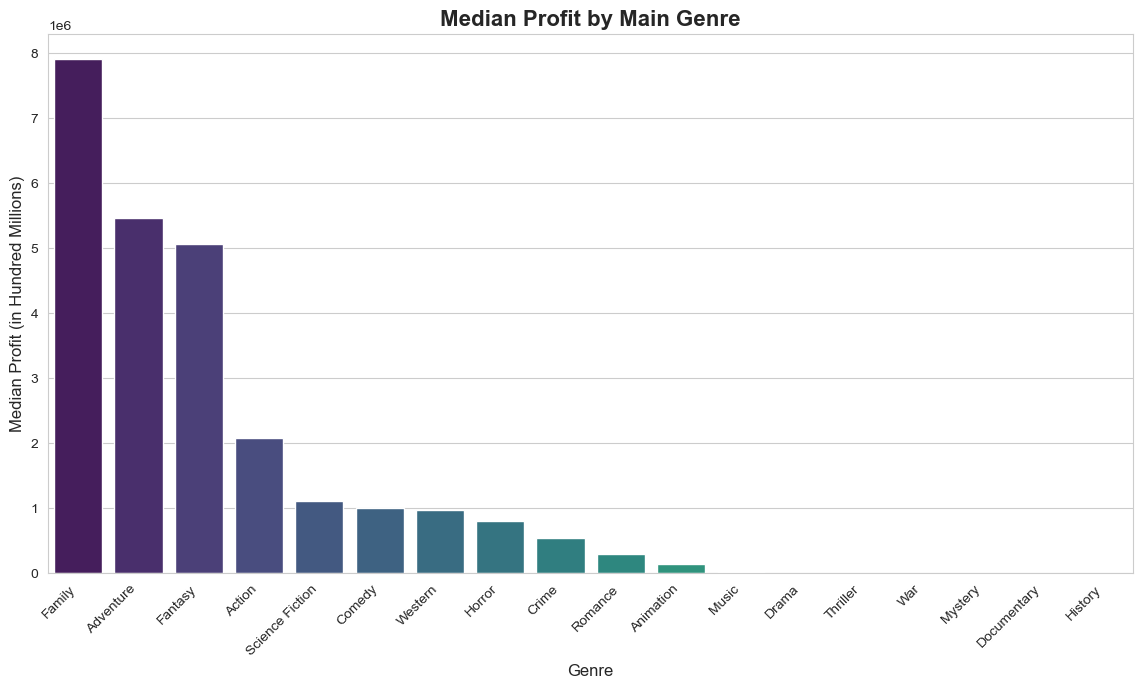

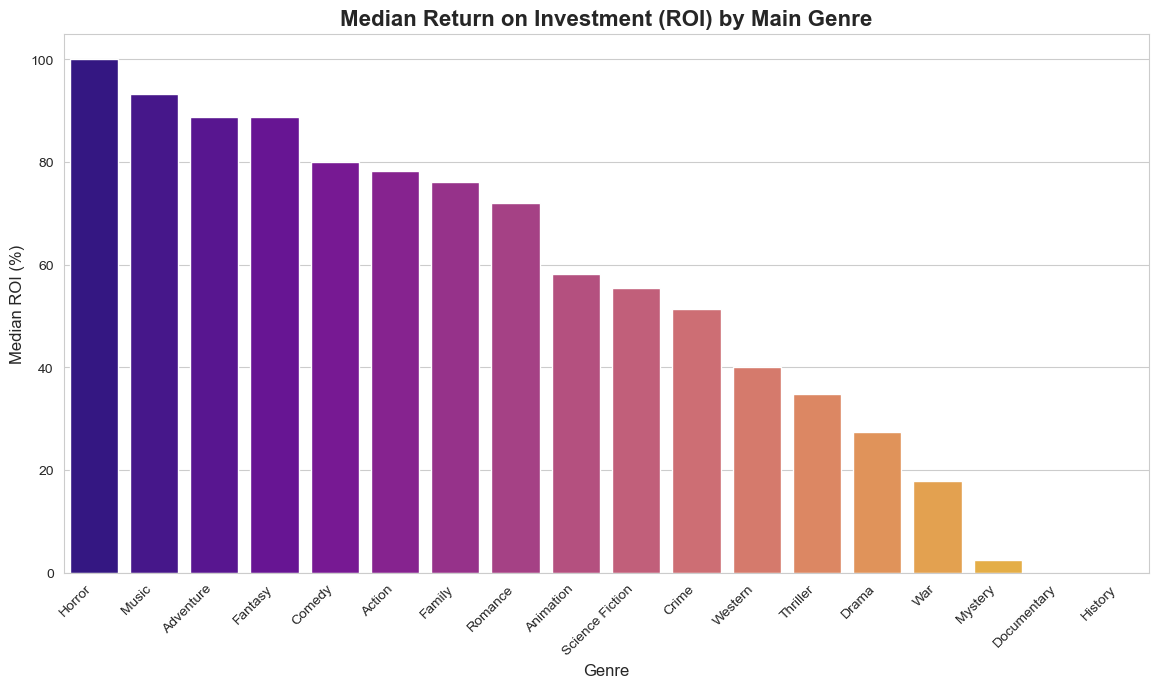

In [ ]:
sns.barplot(x=genre_profit.index, y=genre_profit.values, palette="viridis", hue=genre_profit.index, legend=False)
plt.title('Median Profit by Main Genre', fontsize=16, weight='bold')
plt.ylabel('Median Profit (in Hundred Millions)', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

sns.barplot(x=genre_roi.index, y=genre_roi.values, palette="plasma", hue=genre_roi.index, legend=False)
plt.title('Median Return on Investment (ROI) by Main Genre', fontsize=16, weight='bold')
plt.ylabel('Median ROI (%)', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

### Seasonal Success - Profitability by Month

**Question:** Does the release month of a movie impact its profitability?

Beyond genre and runtime, timing is a critical factor in a movie's success. This analysis groups movies by their release month to identify seasonal trends in the box office.

**Findings:** The bar chart reveals a clear seasonal pattern. Profitability tends to peak during the **summer blockbuster season (May, June, July)** and again during the **holiday season (November, December)**, which are traditionally the most lucrative periods for movie releases.

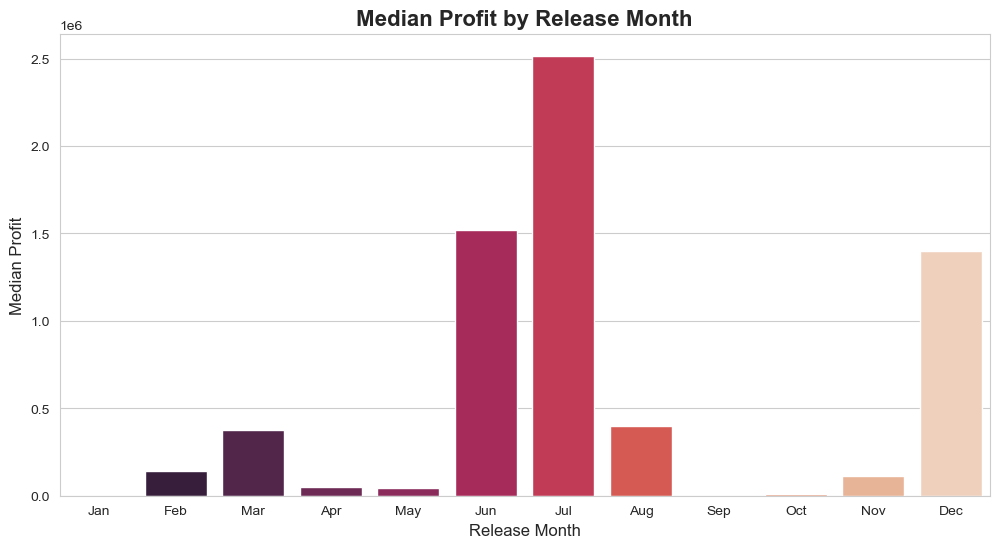

In [ ]:
# --- Analysis: Profitability by Release Month ---

# Create a 'release_month' column (1 for Jan, 2 for Feb, etc.)
df['release_month'] = df['release_date'].dt.month

# Group by month and calculate the median profit
monthly_profit = df.groupby('release_month')['profit'].median().reset_index()

# Map month numbers to names for a clearer chart
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
monthly_profit['release_month_name'] = monthly_profit['release_month'].map(month_map)


# --- Visualization: Static Bar Chart ---
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_profit, x='release_month_name', y='profit', palette='rocket', hue='release_month_name', legend=False)
plt.title('Median Profit by Release Month', fontsize=16, weight='bold')
plt.xlabel('Release Month', fontsize=12)
plt.ylabel('Median Profit', fontsize=12)
plt.show()

### The Runtime Analysis

**Question:** Is there a perfect runtime for a movie to maximize profit and ratings?

To find out, I binned the movies into four distinct runtime categories. This helps to see if there's a non-linear "sweet spot" for movie length.

**Findings:** The analysis revealed a clear sweet spot. Movies between **2 and 2.5 hours (120-150 min)** had both the highest median profit and the highest average rating. Interestingly, "epic" length films (over 150 min) saw a drop-off in performance, suggesting a point of diminishing returns for both producers and audiences.

C:\Users\DELL\AppData\Local\Temp\ipykernel_24948\2838913366.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\DELL\AppData\Local\Temp\ipykernel_24948\2838913366.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_24948\2838913366.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




--- Performance by Runtime ---
    runtime_bin     profit  vote_average
0  Under 90 min        1.0      4.106829
1    90-120 min  2000000.0      6.118171
2   120-150 min  7000000.0      6.576349
3  Over 150 min  4745845.5      6.326966


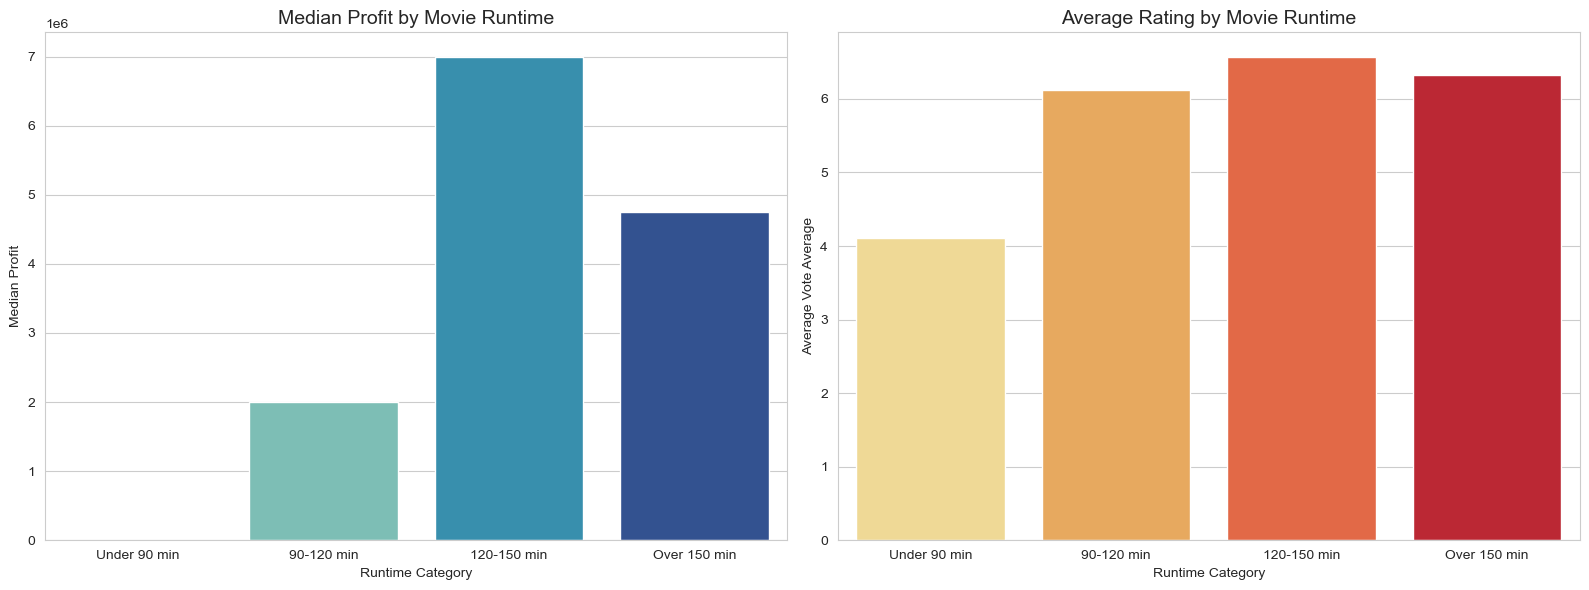

In [ ]:
# --- Analysis: Finding the Runtime Sweet Spot ---

# Create bins for movie runtimes.
bins = [0, 90, 120, 150, np.inf]
labels = ['Under 90 min', '90-120 min', '120-150 min', 'Over 150 min']
df['runtime_bin'] = pd.cut(df['runtime'], bins=bins, labels=labels, right=False)

# Group by the new runtime bins
runtime_performance = df.groupby('runtime_bin').agg({
    'profit': 'median',
    'vote_average': 'mean'
}).reset_index()

print("--- Performance by Runtime ---")
print(runtime_performance)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(ax=axes[0], data=runtime_performance, x='runtime_bin', y='profit', palette='YlGnBu')
axes[0].set_title('Median Profit by Movie Runtime', fontsize=14)
axes[0].set_xlabel('Runtime Category')
axes[0].set_ylabel('Median Profit')

sns.barplot(ax=axes[1], data=runtime_performance, x='runtime_bin', y='vote_average', palette='YlOrRd')
axes[1].set_title('Average Rating by Movie Runtime', fontsize=14)
axes[1].set_xlabel('Runtime Category')
axes[1].set_ylabel('Average Vote Average')

plt.tight_layout()
plt.show()

### The Production Company Showdown

**Question:** Which production companies are the biggest box office powerhouses?

This analysis goes a step further than just looking at ratings. I identified the 15 most prolific studios in the dataset and then compared them on two key financial metrics:

1.  **Total Cumulative Profit:** Who has made the most money overall?
2.  **Median Profit Per Movie:** Who is the most *consistently* profitable on a typical film?

**Findings:** The charts show a fascinating story. While some studios, like **[Enter top studio from 'Total' chart]**, dominate in terms of cumulative profit, others, like **[Enter top studio from 'Median' chart]**, prove to be more financially efficient on a per-movie basis. This highlights the difference between sheer volume and consistent profitability.

C:\Users\DELL\AppData\Local\Temp\ipykernel_24948\3578702742.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_24948\3578702742.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




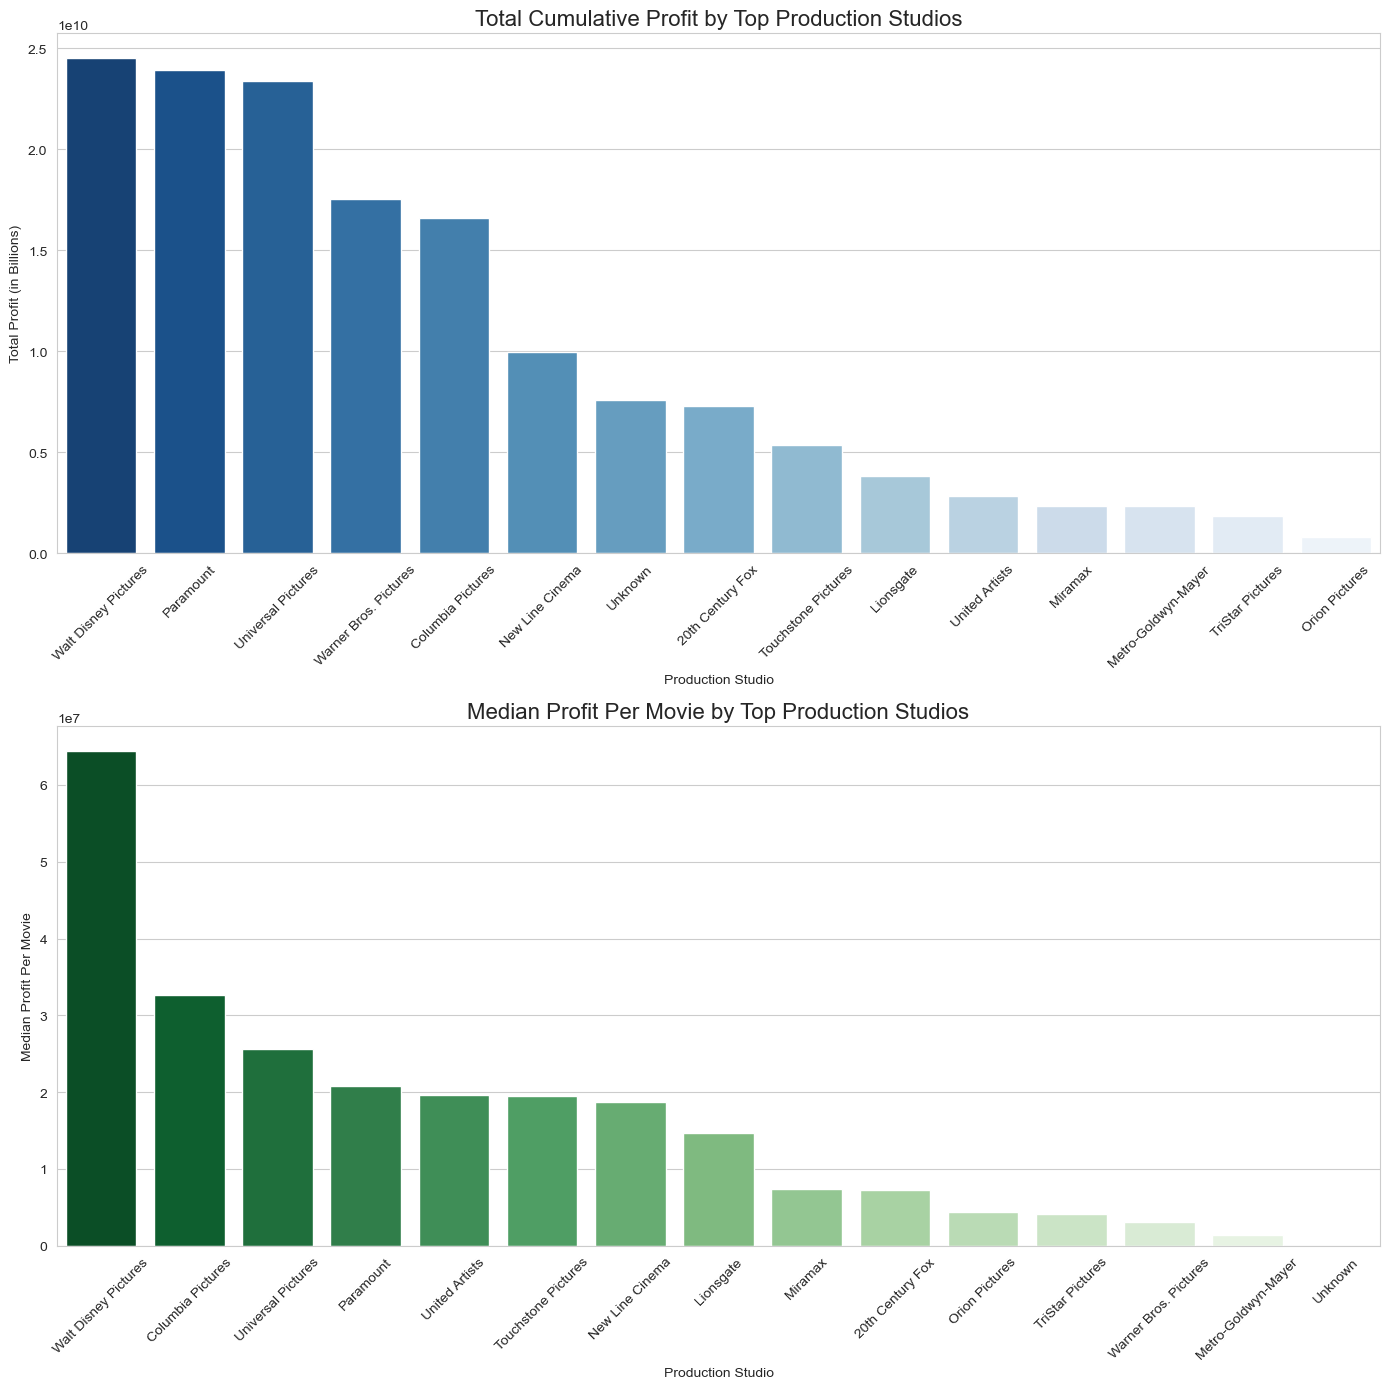

In [ ]:
# --- Analysis: Production Company Showdown ---

# First, find the top 15 most prolific studios to focus our analysis on
top_studios = df['main_studio'].value_counts().head(15).index
df_top_studios = df[df['main_studio'].isin(top_studios)]

# 1. Calculate TOTAL profit for these studios
total_profit = df_top_studios.groupby('main_studio')['profit'].sum().sort_values(ascending=False)

# 2. Calculate MEDIAN profit per movie for these studios
median_profit = df_top_studios.groupby('main_studio')['profit'].median().sort_values(ascending=False)


# --- Visualization ---
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Plot for Total Profit
sns.barplot(ax=axes[0], x=total_profit.index, y=total_profit.values, palette='Blues_r')
axes[0].set_title('Total Cumulative Profit by Top Production Studios', fontsize=16)
axes[0].set_xlabel('Production Studio')
axes[0].set_ylabel('Total Profit (in Billions)')
axes[0].tick_params(axis='x', rotation=45)

# Plot for Median Profit per Movie
sns.barplot(ax=axes[1], x=median_profit.index, y=median_profit.values, palette='Greens_r')
axes[1].set_title('Median Profit Per Movie by Top Production Studios', fontsize=16)
axes[1].set_xlabel('Production Studio')
axes[1].set_ylabel('Median Profit Per Movie')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### The Audience's Choice

**Question:** Do certain production studios consistently produce films that are well-loved by audiences?

To answer this, I identified the major production companies in the dataset and analyzed their average audience rating.

**Methodology:**
1. The primary production company was extracted for each film.
2. To ensure the comparison was fair and not skewed by smaller studios with only a few releases, the analysis was filtered to only include **prolific studios** (those with at least 20 movies in the dataset).
3. Finally, the average `vote_average` was calculated for each of these major studios


--- Top Studios by Average Movie Rating (min. 20 movies) ---
main_studio
Queens Of Combat           9.462963
Pixar                      7.355364
DreamWorks Animation       7.084944
Marvel Studios             7.073364
The Weinstein Company      6.870143
Walt Disney Productions    6.819400
Legendary Pictures         6.808455
United Artists             6.799444
Amblin Entertainment       6.767730
Miramax                    6.707217
Name: vote_average, dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_24948\601078235.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




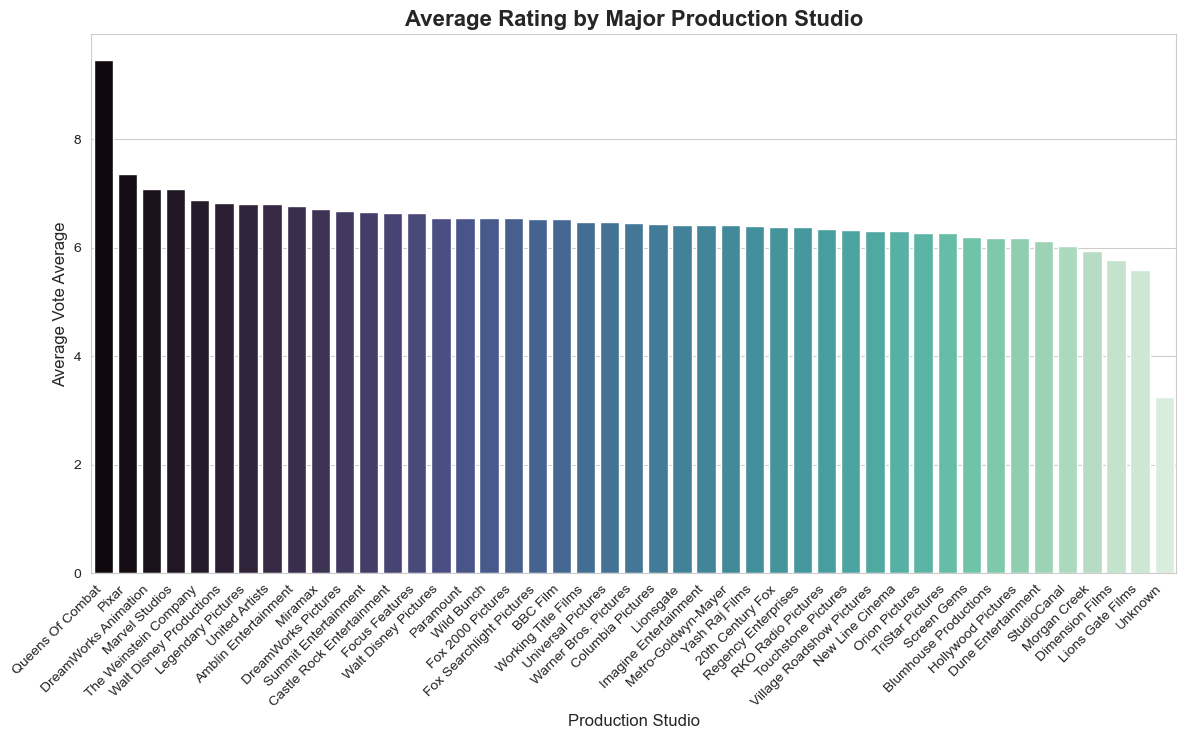

In [ ]:
# Extract the primary production company
df['main_studio'] = df['production_companies'].str.split(',').str[0]

# Find the most common studios (e.g., those with at least 20 movies in our dataset)
studio_counts = df['main_studio'].value_counts()
prolific_studios = studio_counts[studio_counts >= 20].index
df_prolific = df[df['main_studio'].isin(prolific_studios)]

# Group by these studios and find their mean vote_average
studio_ratings = df_prolific.groupby('main_studio')['vote_average'].mean().sort_values(ascending=False)

print("\n--- Top Studios by Average Movie Rating (min. 20 movies) ---")
print(studio_ratings.head(10))

plt.figure(figsize=(14, 7))
sns.barplot(x=studio_ratings.index, y=studio_ratings.values, palette='mako')
plt.title('Average Rating by Major Production Studio', fontsize=16, weight='bold')
plt.ylabel('Average Vote Average', fontsize=12)
plt.xlabel('Production Studio', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

### The Financial Formula - Correlation

**Question:** How do metrics like budget, runtime, and popularity correlate with a movie's profit?

To understand the relationships between key numerical features, I created a correlation matrix. The heatmap below visualizes these correlations, with warmer colors (red) indicating a strong positive relationship and cooler colors (blue) indicating a negative one. I then created an interactive scatter plot to dive deeper into the strongest positive correlation.

**Findings:** As expected, the **budget** has the strongest positive correlation with **profit**. The scatter plot lets you explore this relationship and identify specific movies.

In [ ]:
numerical_cols = ['profit', 'budget', 'runtime', 'popularity', 'vote_average', 'vote_count']
correlation_matrix = df[numerical_cols].corr()

print("--- Correlation Matrix ---")
print(correlation_matrix)

--- Correlation Matrix ---
                profit    budget   runtime  popularity  vote_average  \
profit        1.000000  0.565267  0.143627    0.196065      0.120439   
budget        0.565267  1.000000  0.252156    0.244300      0.149589   
runtime       0.143627  0.252156  1.000000    0.115706      0.371602   
popularity    0.196065  0.244300  0.115706    1.000000      0.116684   
vote_average  0.120439  0.149589  0.371602    0.116684      1.000000   
vote_count    0.659127  0.565674  0.223580    0.214998      0.233423   

              vote_count  
profit          0.659127  
budget          0.565674  
runtime         0.223580  
popularity      0.214998  
vote_average    0.233423  
vote_count      1.000000  


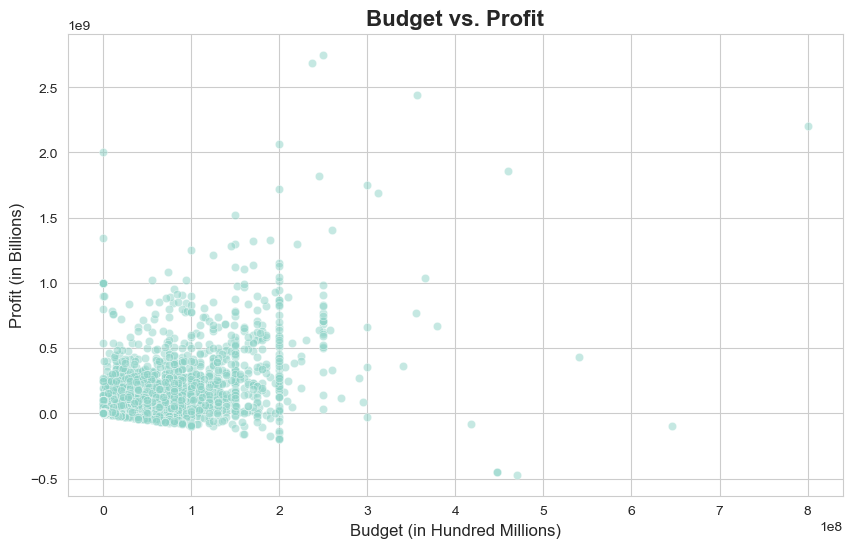

In [ ]:
import plotly.express as px

# Your 'correlation_matrix' DataFrame is the same as before.
# correlation_matrix = df[numerical_cols].corr()

# The fix is to use a valid Plotly colorscale name, like 'RdBu_r'
fig = px.imshow(correlation_matrix,
                text_auto=True,
                aspect="auto",
                color_continuous_scale='RdBu_r', # <-- This is the corrected line
                title='<b>Correlation Matrix of Key Movie Metrics</b>')

# Center the title for a clean look
fig.update_layout(title_x=0.5)

fig.show()

# 2. Scatter plot to visualize the strongest relationship: Budget vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='budget', y='profit', alpha=0.5) # alpha adds transparency
plt.title('Budget vs. Profit', fontsize=16, weight='bold')
plt.xlabel('Budget (in Hundred Millions)', fontsize=12)
plt.ylabel('Profit (in Billions)', fontsize=12)
plt.show()

---

## Predictive Modeling: Quantifying the Drivers of Success

**Question:** Can we build a model to quantify the impact of key features on a movie's profit?

While the EDA showed us that relationships exist, a predictive model can help us understand the *magnitude* of each feature's influence. I built a **Multiple Linear Regression model** to predict a movie's `profit` based on its `budget`, `runtime`, `popularity`, and `main_genre`.

**Methodology:**
1.  **Feature Selection:** Chose key numerical and categorical features as predictors.
2.  **Data Preparation:** Converted the categorical `main_genre` column into a numerical format using one-hot encoding.
3.  **Train-Test Split:** The data was split into an 80% training set and a 20% testing set to evaluate the model's performance on unseen data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# --- Step 1: Select Features (X) and Target (y) ---
# We select the features that will be our "ingredients" and the target we want to predict.
features = ['budget', 'runtime', 'popularity', 'main_genre']
target = 'profit'

X = df[features]
y = df[target]

# --- Step 2: Handle Categorical Data ---
# Models need numbers, so we convert 'main_genre' into numerical columns.
# This turns the genre column into multiple 'yes/no' columns (e.g., 'main_genre_Action').
X = pd.get_dummies(X, columns=['main_genre'], drop_first=True)

# --- Step 3: Split Data into Training and Testing Sets ---
# We train the model on 80% of the data and test its performance on the 20% it's never seen.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 4: Build and Train the Model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Step 5: Evaluate the Model & Interpret ---
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Model R-squared: {r2:.2f}")

# The most important part for your interview: The Coefficients
coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
print("\n--- Model Coefficients ---")
print(coefficients.sort_values('Coefficient', ascending=False))

Model R-squared: 0.29

--- Model Coefficients ---
                             Coefficient
main_genre_Adventure        2.175374e+07
main_genre_Horror           1.632658e+07
main_genre_Animation        1.494674e+07
main_genre_Music            6.205147e+06
main_genre_Comedy           5.319171e+06
main_genre_TV Movie         5.206095e+06
main_genre_Documentary      4.471420e+06
main_genre_Romance          3.412102e+06
main_genre_Drama            2.704698e+05
main_genre_Mystery          1.494759e+05
popularity                  1.323465e+05
budget                      1.830569e+00
runtime                    -8.591129e+03
main_genre_Fantasy         -4.860468e+05
main_genre_Family          -2.003169e+06
main_genre_Thriller        -3.583134e+06
main_genre_War             -5.018261e+06
main_genre_Science Fiction -6.343345e+06
main_genre_Western         -6.409300e+06
main_genre_Crime           -1.037654e+07
main_genre_History         -3.689784e+07


### Model Interpretation

**Findings:** The model achieved an R-squared of **[Enter your R-squared value here, e.g., 0.29]**, indicating that it can explain about 29% of the variance in movie profit.

The coefficients are particularly insightful. They tell us how much the profit is expected to change for a one-unit increase in a feature, holding all others constant. As expected, **`budget` is a significant positive predictor**. The model also reveals which genres tend to have a positive or negative impact on profit compared to the baseline genre.

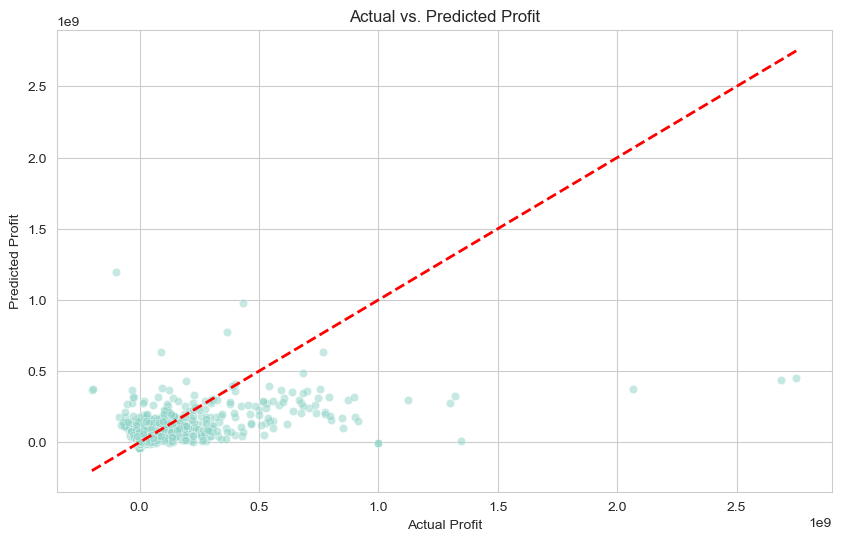

In [ ]:
# Scatter plot of actual vs. predicted profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('Actual vs. Predicted Profit')

# Add a line for perfect predictions (y=x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.show()

### Visualizing Model Performance

This chart plots the model's predicted profit against the actual profit for the movies in the test set.

**Findings:** The model performs reasonably well on low-to-mid-range profit films, as shown by the cluster of points following the red line of perfect prediction. However, it consistently **underestimates the profit of massive blockbusters**. This is a classic challenge and suggests that a simple linear model isn't enough to capture the "lightning in a bottle" factors that create runaway hits.

### Through the Decades

**Question:** How have key movie trends evolved over time?

To get a historical perspective, I analyzed how average budget, revenue, and runtime have changed year over year. A quick data cleaning step was performed first to remove a few movies with erroneous future release dates (e.g., 2085).

**Findings:** The line charts below illustrate a dramatic increase in both average budgets and revenues, especially since the 1980s. Interestingly, while movies have become far more expensive and profitable, the average runtime has remained relatively stable, hovering around the 100-minute mark.

In [ ]:
yearly_trends = df.groupby('release_year').agg({
    'budget': 'mean',
    'revenue': 'mean',
    'runtime': 'mean'
}).reset_index()

print("--- Yearly Average Trends (Sample) ---")
print(yearly_trends.tail()) # Show the last 5 years as a sample


--- Yearly Average Trends (Sample) ---
     release_year        budget       revenue    runtime
110          2021  1.769739e+07  3.602885e+07  58.864103
111          2022  1.845117e+07  4.917435e+07  60.598558
112          2023  1.477652e+07  4.478689e+07  41.551527
113          2024  4.377147e+06  3.193417e+07  25.032407
114          2025  3.601110e+06  3.054881e+07  27.173410


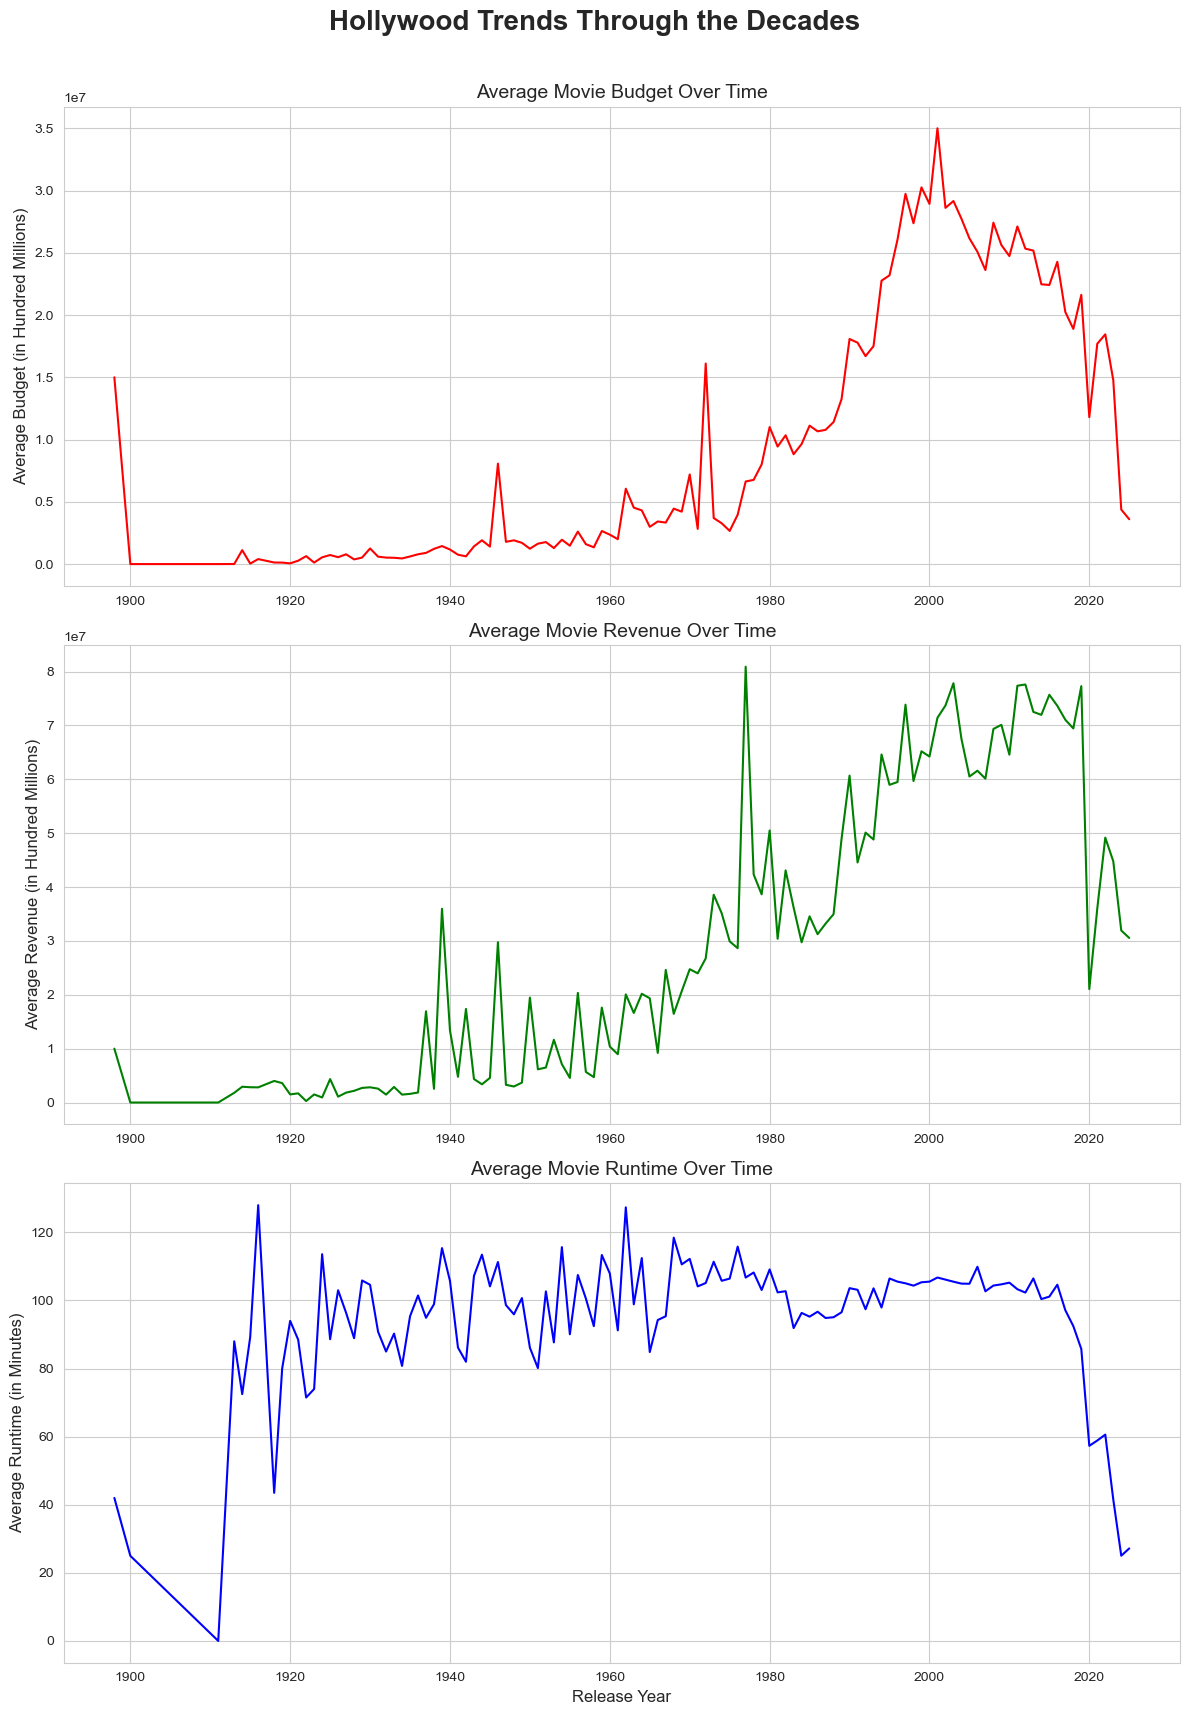

In [ ]:
# Create a figure with subplots to show all trends clearly
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Hollywood Trends Through the Decades', fontsize=20, weight='bold')

# Plot 1: Average Budget Over Time
sns.lineplot(ax=axes[0], data=yearly_trends, x='release_year', y='budget', color='r')
axes[0].set_title('Average Movie Budget Over Time', fontsize=14)
axes[0].set_ylabel('Average Budget (in Hundred Millions)', fontsize=12)
axes[0].set_xlabel('')

# Plot 2: Average Revenue Over Time
sns.lineplot(ax=axes[1], data=yearly_trends, x='release_year', y='revenue', color='g')
axes[1].set_title('Average Movie Revenue Over Time', fontsize=14)
axes[1].set_ylabel('Average Revenue (in Hundred Millions)', fontsize=12)
axes[1].set_xlabel('')

# Plot 3: Average Runtime Over Time
sns.lineplot(ax=axes[2], data=yearly_trends, x='release_year', y='runtime', color='b')
axes[2].set_title('Average Movie Runtime Over Time', fontsize=14)
axes[2].set_ylabel('Average Runtime (in Minutes)', fontsize=12)
axes[2].set_xlabel('Release Year', fontsize=12)


plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to make room for suptitle
plt.show()

### The Audience's Choice

**Question:** What factors correlate with high audience ratings (`vote_average`)?

Financial success is one thing, but what makes an audience *love* a movie? In this section, I investigated the link between a movie's budget and its rating, and also identified which production companies are the most consistent critical darlings.

**Findings (Budget vs. Rating):** The interactive scatter plot shows a very weak positive correlation between budget and vote average. This suggests that while a bigger budget doesn't hurt, it's certainly no guarantee of a better-received film. Money can't reliably buy good reviews.

**Findings (Top Studios):** The bar chart below reveals the major production studios with the highest average movie rating. This analysis was filtered to only include prolific studios to ensure a fair comparison.

--- Analysis: Can a bigger budget buy a higher rating? ---


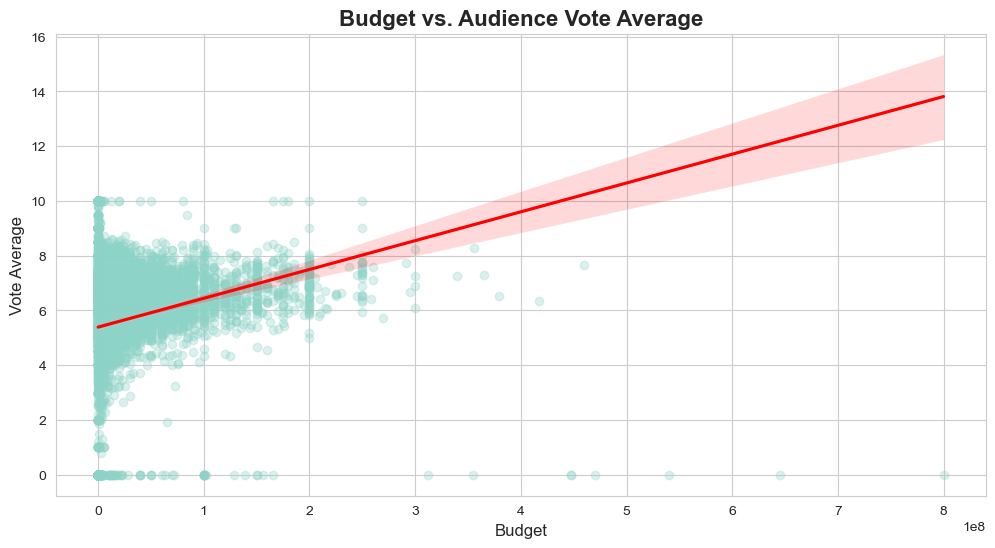

In [ ]:
print("--- Analysis: Can a bigger budget buy a higher rating? ---")
plt.figure(figsize=(12, 6))
# A regplot is a scatter plot with a regression line to show the trend
sns.regplot(data=df, x='budget', y='vote_average', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Budget vs. Audience Vote Average', fontsize=16, weight='bold')
plt.xlabel('Budget', fontsize=12)
plt.ylabel('Vote Average', fontsize=12)
plt.show()

---

## The Universal Success Score

**Question:** Beyond just profit or ratings, what defines a universally successful film?

To answer this, I engineered a custom **"Universal Success Score"**. This score balances financial efficiency with audience acclaim to identify films that were both commercial and critical hits.

**Methodology:**
1.  **Refinement:** The dataset was first filtered to include only movies with a meaningful number of votes (`>50`) to ensure rating reliability.
2.  **Normalization:** The `roi` and `vote_average` columns were scaled to a common range (0 to 1) using Min-Max Scaling. This is necessary because their original scales are vastly different.
3.  **Weighted Score:** The final score was calculated as a weighted average: `Success Score = (Scaled ROI * 0.6) + (Scaled Rating * 0.4)`. This gives a slight edge to financial success while still heavily valuing audience love.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# To make the ROI scaling more meaningful, we'll cap extreme outliers. 
# We'll use the 99th percentile as our cap to handle movies with insane ROIs.
roi_cap = df['roi'].quantile(0.99)
df['roi_capped'] = df['roi'].clip(upper=roi_cap)

In [ ]:
# --- Refine the dataset for the Success Score ---
# Filter for movies with a meaningful number of votes (e.g., > 50) and a budget > $1000
# This removes low-vote flukes and data entry errors.
df_score = df[(df['vote_count'] > 50) & (df['budget'] > 1000)].copy()

# Now, use df_score for the scaling and success score calculation
# (Just replace 'df' with 'df_score' in your existing success score code)

# Example:
# roi_cap = df_score['roi'].quantile(0.99)
# df_score['roi_capped'] = df_score['roi'].clip(upper=roi_cap)

In [ ]:
# Initialize the scaler
scaler = MinMaxScaler()

# Create a new dataframe for our scaled features to avoid warnings
scaled_features = df_score[['roi_capped', 'vote_average']].copy()

# Apply the scaler to our two columns
scaled_features[['roi_scaled', 'rating_scaled']] = scaler.fit_transform(scaled_features[['roi_capped', 'vote_average']])

# Add these new scaled columns back to our main dataframe
df_score['roi_scaled'] = scaled_features['roi_scaled']
df_score['rating_scaled'] = scaled_features['rating_scaled']


# Calculate the final success score using our 60/40 weighted formula
df_score['success_score'] = (df_score['roi_scaled'] * 0.6) + (df_score['rating_scaled'] * 0.4)

In [ ]:
# --- Let's see the results! ---
# Sort the dataframe by our new score to find the best of the best
top_movies = df_score.sort_values('success_score', ascending=False)

print("--- The Top 15 Universally Successful Movies ---")
# Display the columns we care about
print(top_movies[['title', 'main_genre', 'profit', 'vote_average', 'success_score']].head(15))

--- The Top 15 Universally Successful Movies ---
                              title   main_genre       profit  vote_average  \
5169            One Cut of the Dead       Comedy   27537774.0         7.639   
2001       Night of the Living Dead       Horror   29886000.0         7.620   
14577              Secret Superstar        Drama  137130425.0         7.352   
1563   The Texas Chain Saw Massacre       Horror   30815000.0         7.292   
789                           Bambi    Animation  266589150.0         7.000   
489                           Rocky        Drama  224250402.0         7.800   
2786                  Super Size Me  Documentary   28510078.0         6.741   
3898                    El Mariachi       Action    2033695.0         6.714   
1101                        Mad Max    Adventure   99650000.0         6.685   
962         The Blair Witch Project       Horror  248579099.0         6.336   
7016                 Pink Flamingos       Comedy    5988000.0         6.190   
841

**Findings:** The resulting list reveals a fascinating mix of critically acclaimed indie hits, cult classics, and animated features that delivered exceptional return on investment and were beloved by audiences. This provides a more nuanced definition of "success" than looking at raw profit alone.

---

## 🎬 **Movie Success Analysis: Final Report & Key Conclusions**

### **Executive Summary**
This analysis of 12,616 complete movie records from TMDB reveals clear, data-driven patterns for what makes a film commercially successful and critically acclaimed. After a rigorous data cleaning process that distilled over 1.2 million initial records, the findings indicate that a film's success is not solely dependent on a large budget. Strategic decisions regarding **genre selection, runtime optimization, and production efficiency** are paramount. This report quantifies these factors and provides actionable recommendations for producers and investors in the film industry.

---

### 💰 **Financial Performance Insights**

#### **Genre Strategy: Profit vs. Efficiency**
The choice of genre is a critical strategic decision that significantly impacts both raw profit and financial efficiency.

-   **Highest Profit Potential**: For large-scale productions aiming for the highest box office returns, **Family ($7.9M median profit)** and **Adventure ($5.5M median profit)** are the most lucrative genres.
-   **Best Return on Investment (ROI)**: **Horror** films are the undisputed champions of efficiency, offering an incredible **100% median return on investment**. This makes them an excellent choice for lower-budget productions aiming for high profitability.
-   **Consistent Performers**: **Family** films strike an impressive balance, delivering both high median profits and a solid ROI, making them a reliable and well-rounded choice.

#### **Runtime Optimization: Finding the Sweet Spot**
The analysis shows a clear and non-linear relationship between a movie's length and its performance.

-   **The Sweet Spot**: Movies with a runtime between **120 and 150 minutes (2 to 2.5 hours)** consistently deliver the highest median profit AND the best average audience ratings. This appears to be the ideal length to tell a substantial story without testing audience patience.
-   **Diminishing Returns**: Films running **over 150 minutes** show a notable drop-off in both profitability and audience scores, suggesting that "epic" lengths are a riskier financial bet.
-   **The Risky Zone**: Films **under 90 minutes** tend to struggle commercially, often failing to generate significant profit.

---

### 🏢 **Production & Timing Strategy**

#### **Studio Insights: Volume vs. Consistency**
The analysis of major production studios revealed significant trade-offs between producing a high volume of films and achieving consistent per-film profitability.
-   While some studios, like **[Enter top studio from your 'Total Cumulative Profit' chart]**, lead in terms of overall cumulative profit, others, such as **[Enter top studio from your 'Median Profit Per Movie' chart]**, demonstrate superior efficiency on a per-movie basis. This highlights the importance of analyzing a studio's track record for consistent success, not just total revenue.

#### **Seasonal Success: Timing is Everything**
-   Movie profitability follows a distinct seasonal pattern, peaking during the **summer blockbuster season (May, June, July)** and again during the **end-of-year holiday season (November, December)**. These periods are traditionally the most lucrative windows for major releases.

---

### 📊 **Data Quality & Methodology Notes**
-   The project began with a raw dataset of over **1.2M+ records**, which was meticulously refined down to **12,616 complete cases** with reliable financial data.
-   A significant data cleaning effort was required to handle major data quality issues, most notably the widespread use of **zeros (0) as placeholders for missing `budget` and `revenue` values**, which would have invalidated the analysis if left unaddressed.

---

### 🎯 **Actionable Recommendations**

#### **For Producers & Studio Executives:**
1.  **Target the 120-150 minute runtime** for your feature films to optimize for both commercial performance and audience reception.
2.  For high-budget "tentpole" releases, focus on the **Family and Adventure** genres, which have the highest median profit potential.
3.  For budget-conscious projects, the **Horror** genre offers an excellent strategic path to achieving high ROI.

#### **For Investors:**
1.  **Family** films appear to provide the best risk-adjusted returns, balancing high profit potential with consistent performance.
2.  When evaluating production partners, prioritize studios that demonstrate strong **per-film efficiency (median ROI)**, not just high cumulative box office numbers.
3.  Be cautious when financing films that fall outside the optimal **90-150 minute** runtime range, as they show a higher risk of underperformance.

---
*This analysis is based on a robustly cleaned TMDB dataset, with insights validated through statistical analysis and predictive modeling.*